### Get vegetation out of salty bois
- load modules
- load data from virtual product
- cry

In [ ]:
pwd

In [1]:
%matplotlib inline

import sys
import datacube
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datacube.virtual import catalog_from_file

sys.path.append('Scripts')
from dea_plotting import rgb
from dea_plotting import display_map

dc = datacube.Datacube(app='Virtual_products')

In [20]:
# Set the central latitude and longitude
central_lat = -31.6
central_lon = 135.9

# Set the buffer to load around the central coordinates
buffer = 0.3

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

x = (350000, 400000)
y = (-3500000, -3450000)

display_map(x=x, y=y, crs='EPSG:3577', margin=-0.2)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: h

In [5]:
from datacube.virtual import catalog_from_file
#load your catalog
catalog = catalog_from_file('/home/jovyan/your_yaml.yaml')

#Then you can load products from the catalogue
# query
x = study_area_lon#(800000, 900000)
y = study_area_lat#(-2800000, -2700000)
res = (-100, 100)
crs = "EPSG:4326"
time = ("2018-01-01", "2018-06-06")
query =({'time': time,
             'x':x,
            'y':y,
            'crs':crs,
            'resolution':res, 
            'output_crs':'EPSG:3577'})

# load combined gm from virtual prodpuct
product = catalog['ls_fc_daily']
fc = product.load(dc, **query)

In [6]:
fc

<xarray.Dataset>
Dimensions:      (time: 39, x: 585, y: 690)
Coordinates:
    spatial_ref  int32 0
  * x            (x) float64 3.374e+05 3.376e+05 ... 3.958e+05 3.958e+05
  * y            (y) float64 -3.414e+06 -3.414e+06 ... -3.483e+06 -3.483e+06
  * time         (time) datetime64[ns] 2018-01-01T00:51:03 ... 2018-06-03T00:43:54
Data variables:
    BS           (time, y, x) int16 0 0 0 0 0 56 55 0 0 36 ... 0 0 0 0 0 0 0 0 0
    PV           (time, y, x) int16 24 30 28 29 31 6 4 12 ... 118 112 92 8 0 0 0
    NPV          (time, y, x) int16 79 73 74 73 71 37 40 ... 0 16 94 101 101 101
    UE           (time, y, x) int16 11 11 9 9 9 6 5 9 ... 46 46 51 41 11 9 11 10
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

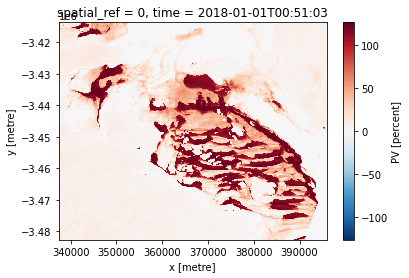

In [7]:
fc1 = fc.isel(time=0).PV
fc1.plot()


### Load geomedian

In [8]:
ds = dc.load(product="ls8_nbart_geomedian_annual",**query)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 1, x: 585, y: 690)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01
  * y            (y) float64 -3.414e+06 -3.414e+06 ... -3.483e+06 -3.483e+06
  * x            (x) float64 3.374e+05 3.376e+05 ... 3.958e+05 3.958e+05
    spatial_ref  int32 0
Data variables:
    blue         (time, y, x) int16 1518 2689 3767 3945 ... 2246 2285 2585 2824
    green        (time, y, x) int16 1785 3047 4316 4493 ... 2491 2562 2858 3107
    red          (time, y, x) int16 2188 3551 4998 5152 ... 2618 2745 3107 3384
    nir          (time, y, x) int16 2368 3750 5212 5312 ... 1675 1910 2661 3052
    swir1        (time, y, x) int16 1812 1452 1326 1385 ... 575 599 962 1045
    swir2        (time, y, x) int16 1163 858 729 770 774 ... 147 322 341 545 600
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


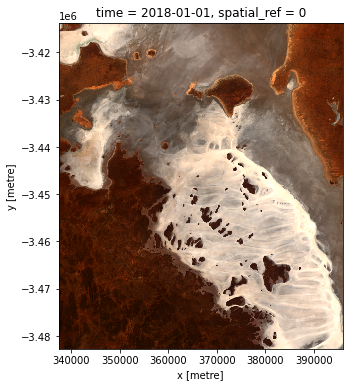

In [9]:
rgb(ds,bands=['red','green','blue'])

### Define VSSI

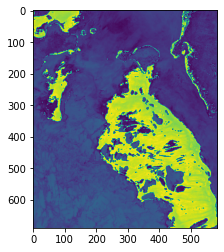

In [10]:
ds['vssi'] = 2*ds['green']-5*(ds['red']+ds['nir'])
plt.imshow(ds['vssi'].isel(time=0))

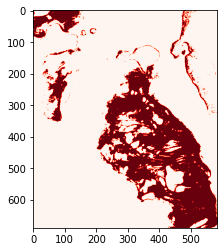

In [11]:
salty_mask = np.where(ds['vssi'].isel(time=0) > 1000, 1, 0)
plt.imshow(salty_mask,cmap='Reds', vmin=0, vmax=1)

In [12]:
salty_mask

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
co = ds.max(dim='time').swap_dims({"x": "y"}).coords
co

ValueError: replacement dimension 'y' is not a 1D variable along the old dimension 'x'

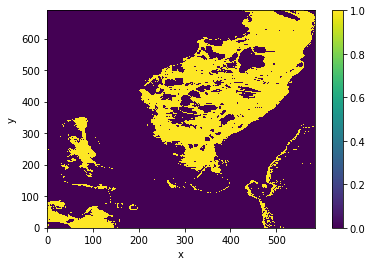

In [14]:
# Convert to xr DataArray
salty_mask1 = xr.DataArray(salty_mask,dims=['y','x'])
salty_mask1.plot()

In [15]:
np.unique(salty_mask)

array([0, 1])

In [16]:
fc1

<xarray.DataArray 'PV' (y: 690, x: 585)>
array([[24, 30, 28, ...,  1,  0,  0],
       [32, 43, 33, ...,  6,  3,  0],
       [34, 39, 38, ...,  7,  7,  4],
       ...,
       [11,  7,  8, ..., -1, -1, -1],
       [12,  8,  8, ..., -1, -1, -1],
       [11, 11, 10, ..., -1, -1, -1]], dtype=int16)
Coordinates:
    spatial_ref  int32 0
  * x            (x) float64 3.374e+05 3.376e+05 ... 3.958e+05 3.958e+05
  * y            (y) float64 -3.414e+06 -3.414e+06 ... -3.483e+06 -3.483e+06
    time         datetime64[ns] 2018-01-01T00:51:03
Attributes:
    units:         percent
    nodata:        -1
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [17]:
salty_mask1

<xarray.DataArray (y: 690, x: 585)>
array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Dimensions without coordinates: y, x

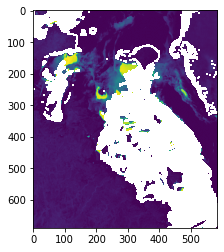

In [18]:
# Mask fc image
masked = fc1.where(salty_mask1==0)
plt.imshow(masked)